# Autoencoder for ml cup dataset

Import some useful stuff

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Dropout, concatenate
import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from keras import Model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import keras_tuner as kt
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import statistics as stats
import time

In [3]:
df = pd.read_csv('ML-CUP_prepro.csv')

In [4]:
x_df = df.drop(['Target_1', 'Target_2'], axis=1)

X_df = df.drop(['Target_1', 'Target_2'], axis=1)
y_df = df[["Target_1", "Target_2"]]
X = X_df.values
y = y_df.values
y_1 = y_df.Target_1.values.reshape(-1, 1)
y_2 = y_df.Target_2.values.reshape(-1, 1)

autoencoder model (complete, many hp)

In [77]:
#with dropout
def get_autoenc(hp):
    n_features_in_ = 9
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    
    hp_units = hp.Choice('units',[25,30,40,50])
    hp_dropout = hp.Choice('dropout', [ 1e-2, 1e-3, 0.0])
    hp_depth = hp.Int('depth', min_value=2, max_value=8, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_decay = hp.Choice('decay', values=[0.0, 1e-4, 1e-3,1e-2])
    
    for i in range(hp_depth+1):
        model.add(Dropout(hp_dropout))
        fun = lambda x: round(hp_units/10 +9*hp_units/10*(np.cos(np.pi*x/hp_depth))**2)
        model.add(Dense(fun(i), activation='relu'))
        
    model.add(keras.layers.Dense(n_features_in_))
    model.compile(loss='MSE', optimizer=Adam(learning_rate=hp_learning_rate, decay=hp_decay))
    return model

smaller hp space model for autoencoder

In [7]:
def get_autoenc(hp):
    n_features_in_ = 9
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    
    hp_units = hp.Choice('units',[25,30,40,50])
    hp_dropout = hp.Choice('dropout', [0.0])
    hp_depth = hp.Int('depth', min_value=4, max_value=8, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_decay = hp.Choice('decay', values=[0.0, 1e-4, 1e-3,1e-2])
    
    for i in range(hp_depth+1):
        model.add(Dropout(hp_dropout))
        fun = lambda x: round(hp_units/10 +9*hp_units/10*(np.cos(np.pi*x/hp_depth))**2)
        model.add(Dense(fun(i), activation='relu'))
        
    model.add(keras.layers.Dense(n_features_in_))
    model.compile(loss='MSE', optimizer=Adam(learning_rate=hp_learning_rate, decay=hp_decay))
    return model

encoder model mirroring smaller autoencoder model

In [26]:
def get_encoder(hp):
    n_features_in_ = 9
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    
    hp_units = hp.Choice('units',[25,30,40,50])
    hp_dropout = hp.Choice('dropout', [0.0])
    hp_depth = hp.Int('depth', min_value=4, max_value=8, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_decay = hp.Choice('decay', values=[0.0, 1e-4, 1e-3,1e-2])
    
    for i in range(hp_depth+1):
        if i<=(hp_depth+1)//2:
            model.add(Dropout(hp_dropout))
            fun = lambda x: round(hp_units/10 +9*hp_units/10*(np.cos(np.pi*x/hp_depth))**2)
            model.add(Dense(fun(i), activation='relu',trainable=False))
    
    model.compile(loss='MSE', optimizer=Adam(learning_rate=hp_learning_rate, decay=hp_decay))
    return model

## fun
in order to create the classic bottleneck shape while changing the number of total layers, we transform the cos^2 (ranging in [0,1]) so that: 
- codomain: [hp_units/10, hp_units]
- minimum in hp_depth/2.
<br>
Downside: we don't know a priori the size in the center of the bottleneck(hp_units/10). So if u have any ideas to improve this model pls tell me :)

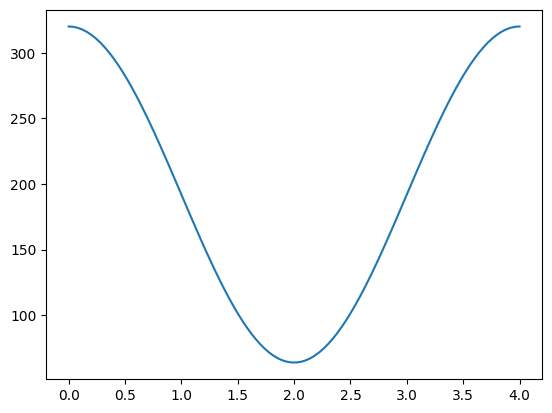

0 2
1 2
2 2


In [5]:
hp_depth=4
hp_units=256
xx=np.linspace(0, hp_depth,100)
fun = lambda x: hp_units/4 +3*hp_units/3*(np.cos(np.pi*x/hp_depth))**2
plt.plot(xx, fun(xx))
plt.show()
for i in range(hp_depth+1):
    if i<=(hp_depth+1)//2:
        print(i,(hp_depth+1)//2)


    

 K-fold CV for Test with internal Hold-out for model selection


Trial 30 Complete [00h 00m 04s]
val_loss: 0.11017432808876038

Best val_loss So Far: 0.0705462247133255
Total elapsed time: 00h 02m 44s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in tuner/autoencoder2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.0705462247133255
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.07107029855251312
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.0722561776638031
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.07606525719165802
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.08444540947675705
Trial summary
Hyperparameters:
units: 50
dropout: 0.0
depth: 6
learning_rate: 0.01
decay: 0.0
Score: 0.08605118840932846
Trial summary
Hyperparameters:
un

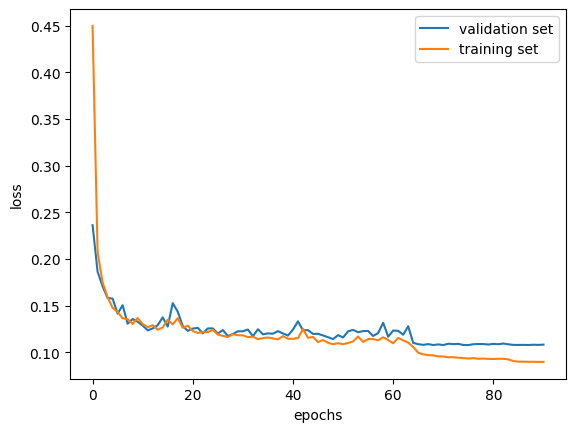

10/10 [==============================] - 0s 478us/step - loss: 0.1198
Elapsed time for this iteration: 167.59 seconds
Expected loss:0.1+/-0.0


In [22]:


outer_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
loss=[]
val_loss=[]   
best_par_list=[]

for dev_idx, test_idx in outer_kfold.split(X): 
    start = time.time()
    X_dev, X_test = X[dev_idx], X[test_idx]
    y_dev, y_test = y[dev_idx], y[test_idx]

    tuner = kt.BayesianOptimization(get_autoenc,
                     objective='val_loss',
                     max_trials=30,
                     overwrite=True,
                     directory='tuner',
    project_name='autoencoder2')

    tuner.search(X_dev, X_dev, epochs=500, validation_split=0.2, 
                callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=10, verbose=1)])
    
    tuner.results_summary()
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    best_par_list.append(best_hps)

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_dev,X_dev,validation_split=0.3,epochs=500,verbose=1, callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, verbose=1)
                ])
    plt.plot(history.history["val_loss"], label='validation set')
    plt.plot(history.history["loss"], label='training set')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    loss.append(model.evaluate(X_test, X_test)) 
    val_loss.append(history.history["val_loss"][-1])
    if val_loss and history.history["val_loss"][-1] == min(val_loss):
        model.save_weights("weights_auto.h5")

    end = time.time()
    print(f'Elapsed time for this iteration: {round(end-start, 2)} seconds')
    
#get best hps according to lowest loss score   
i=val_loss.index(min(val_loss))
best_hps = best_par_list[i]

print(f"Expected loss:{round(stats.mean(loss),2)}+/-{round(stats.variance(loss),2)}")

Now let's load these weights onto an encoder model

In [27]:
encoder = get_encoder(best_hps)
encoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_19 (Dropout)        (None, 9)                 0         
                                                                 
 dense_21 (Dense)            (None, 50)                500       
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 39)                1989      
                                                                 
 dropout_21 (Dropout)        (None, 39)                0         
                                                                 
 dense_23 (Dense)            (None, 16)                640       
                                                                 
 dropout_22 (Dropout)        (None, 16)               

In [28]:
def get_reg_multiOutput(hp):
    model = get_encoder(best_hps)
    
    hp_units = hp.Choice('units',[25,50])
    hp_dropout = hp.Choice('dropout', [ 1e-2, 1e-3, 0.0])
    hp_depth = hp.Int('depth', min_value=2, max_value=8, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_decay = hp.Choice('decay', values=[0.0, 1e-4, 1e-3,1e-2])
    
    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_units, activation='relu'))
    for i in range(hp_depth):
        model.add(Dropout(hp_dropout))
        model.add(Dense(hp_units, activation='relu'))
        
    model.add(keras.layers.Dense(2))
    model.compile(loss='MSE', optimizer=Adam(learning_rate=hp_learning_rate, decay=hp_decay))
    return model


Trial 30 Complete [00h 00m 05s]
val_loss: 10.65218448638916

Best val_loss So Far: 4.530158519744873
Total elapsed time: 00h 03m 55s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in tuner/merged_encoder
Showing 10 best trials
Trial summary
Hyperparameters:
units: 50
dropout: 0.01
depth: 8
learning_rate: 0.01
decay: 0.0
Score: 4.530158519744873
Trial summary
Hyperparameters:
units: 50
dropout: 0.01
depth: 8
learning_rate: 0.001
decay: 0.0
Score: 4.713797569274902
Trial summary
Hyperparameters:
units: 50
dropout: 0.01
depth: 8
learning_rate: 0.01
decay: 0.01
Score: 5.756580352783203
Trial summary
Hyperparameters:
units: 50
dropout: 0.01
depth: 8
learning_rate: 0.001
decay: 0.0
Score: 6.113801956176758
Trial summary
Hyperparameters:
units: 50
dropout: 0.01
depth: 8
learning_rate: 0.001
decay: 0.0
Score: 6.4226202964782715
Trial summary
Hyperparameters:
units: 25
dropout: 0.01
depth: 8
learning_rate: 0.01
decay: 0.01
Score: 6.594037055969238
Trial summary
Hyperparameters:
u

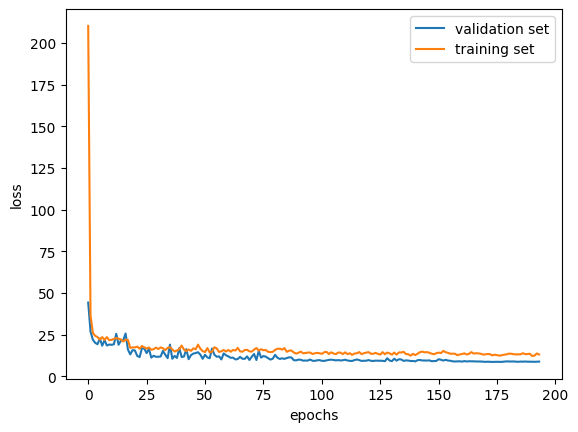

10/10 [==============================] - 0s 500us/step - loss: 12.2020
Elapsed time for this iteration: 244.89 seconds
Expected loss:12.34+/-38.9


In [29]:
outer_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
loss=[]
val_loss=[]   
best_par_list=[]

for dev_idx, test_idx in outer_kfold.split(X): 
    start = time.time()
    X_dev, X_test = X[dev_idx], X[test_idx]
    y_dev, y_test = y[dev_idx], y[test_idx]

    tuner = kt.BayesianOptimization(get_reg_multiOutput,
                     objective='val_loss',
                     max_trials=30, overwrite=True,
                     directory='tuner',
    project_name='merged_encoder')

    tuner.search(X, y, epochs=500, validation_split=0.2, 
                callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=10, verbose=1)])
             
    tuner.results_summary()
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    best_par_list.append(best_hps)

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_dev,y_dev,validation_split=0.3,epochs=500,verbose=1, callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, verbose=1)
                ])
    plt.plot(history.history["val_loss"], label='validation set')
    plt.plot(history.history["loss"], label='training set')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    loss.append(model.evaluate(X_test, y_test)) 
    val_loss.append(history.history["val_loss"][-1])
    if val_loss and history.history["val_loss"][-1] == min(val_loss):
        model.save_weights("weights_auto.h5")

    end = time.time()
    print(f'Elapsed time for this iteration: {round(end-start, 2)} seconds')
    
#get best hps according to lowest loss score   
i=val_loss.index(min(val_loss))
best_hps = best_par_list[i]

print(f"Expected loss:{round(stats.mean(loss),2)}+/-{round(stats.variance(loss),2)}")

fa schifo!!